# 딥러닝을 적용한 추천 시스템


In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split

import os
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.python.keras.layers import Dense, Concatenate, Activation
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.optimizer_v1 import SGD, Adamax

tf.compat.v1.disable_eager_execution()

base_src = '../data/drive-download-20240102T142504Z-001'
u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(
    u_data_src,
    sep='\t',
    names=r_cols,
    encoding='latin-1'
)

rating_train, rating_test = train_test_split(ratings, test_size=0.2, shuffle=True, random_state=2021)

# y_true, y_pred는 신경망에서 실제값, 예측값을 나타내는 Tensorflow/keras 표준 변수
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# vartiable 초기화
# 잠재요인의 수를 200으로 설정
K = 200
# 전체평균 계산
mu = rating_train.rating.mean()
# 사용자 아이디와 영화 아이디의 최대값을 구한다. movie lens데이터는 잘 정제되어 있어서 max 사용
# +1를 해주는 이유는 나중에 bias trem의 크기 1를 추가로 고려
M = rating_train.user_id.max() + 1 
N = rating_train.movie_id.max() + 1

################################################################################################
# keras model
# 아래 부분은 앞에서와 동일하게 사용자와 아이템 데이터를 embedding을 통해
# 각각 K개의 노드를 갖는 layer로 변환하고 
# 사용자 bias와 아이템 bias를 1개의 노드를 갖는 layer로 변환한다.
user = Input(shape=(1,))
item = Input(shape=(1,))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])
# node 2048개
R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)

R = Dense(1)(R)

model = Model(inputs=[user, item], outputs=R)

model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 200)       188800      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 200)       336600      input_6[0][0]                    
______________________________________________________________________________________________

In [4]:
# model fitting
train_user_ids = rating_train.user_id.values
train_movie_ids = rating_train.movie_id.values
train_ratings = rating_train.rating.values

test_user_ids = rating_test.user_id.values
test_movie_ids = rating_test.movie_id.values
test_ratings = rating_test.rating.values

result = model.fit(
    x=[train_user_ids, train_movie_ids],
    y=train_ratings - mu,
    epochs=65,
    batch_size=512,
    validation_data=(
        [test_user_ids, test_movie_ids],
        test_ratings - mu
    )
)


Train on 80000 samples, validate on 20000 samples
Epoch 1/65


2024-01-14 06:08:42.912194: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-14 06:08:42.998902: W tensorflow/c/c_api.cc:305] Operation '{name:'SGD/lr/Assign' id:290 op device:{requested: '', assigned: ''} def:{{{node SGD/lr/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](SGD/lr, SGD/lr/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


79872/80000 [============================>.] - ETA: 0s - loss: 5.3868 - RMSE: 1.1263

/Users/jaypark/anaconda3/lib/python3.11/site-packages/tensorflow/python/keras/engine/training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2024-01-14 06:08:47.032239: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/AddN_1' id:404 op device:{requested: '', assigned: ''} def:{{{node loss/AddN_1}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, loss/AddN)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


80000/80000 [==============================] - 4s 54us/sample - loss: 5.3866 - RMSE: 1.1263 - val_loss: 5.2438 - val_RMSE: 1.1159
Epoch 2/65
80000/80000 [==============================] - 4s 55us/sample - loss: 5.1254 - RMSE: 1.1242 - val_loss: 4.9908 - val_RMSE: 1.1181
Epoch 3/65
80000/80000 [==============================] - 4s 54us/sample - loss: 4.8802 - RMSE: 1.1227 - val_loss: 4.7534 - val_RMSE: 1.1178
Epoch 4/65
80000/80000 [==============================] - 5s 58us/sample - loss: 4.6499 - RMSE: 1.1208 - val_loss: 4.5303 - val_RMSE: 1.1148
Epoch 5/65
80000/80000 [==============================] - 4s 55us/sample - loss: 4.4334 - RMSE: 1.1197 - val_loss: 4.3208 - val_RMSE: 1.1094
Epoch 6/65
80000/80000 [==============================] - 4s 55us/sample - loss: 4.2300 - RMSE: 1.1173 - val_loss: 4.1238 - val_RMSE: 1.1116
Epoch 7/65
80000/80000 [==============================] - 4s 54us/sample - loss: 4.0389 - RMSE: 1.1158 - val_loss: 3.9386 - val_RMSE: 1.1009
Epoch 8/65
80000/80000 [

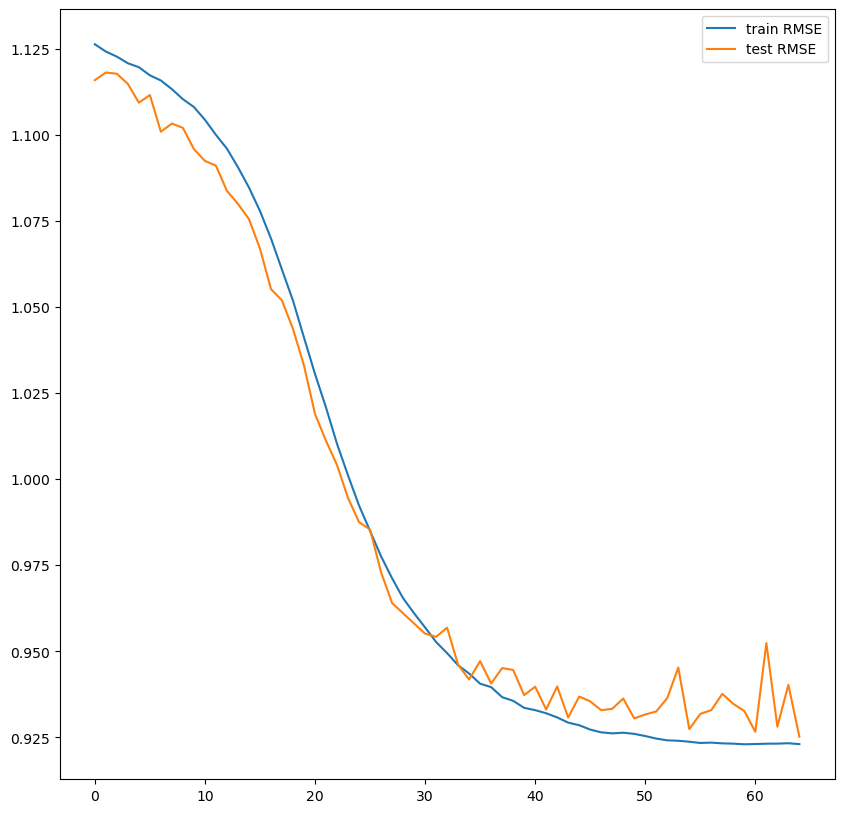

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(result.history['RMSE'], label='train RMSE')
plt.plot(result.history['val_RMSE'], label='test RMSE')
plt.legend()
plt.show()

In [6]:
user_ids = rating_train.user_id.values[0:6]
movie_ids = rating_train.movie_id.values[0:6]

predictions = model.predict([user_ids, movie_ids]) + mu

/Users/jaypark/anaconda3/lib/python3.11/site-packages/tensorflow/python/keras/engine/training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2024-01-14 06:14:09.016432: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_3/BiasAdd' id:281 op device:{requested: '', assigned: ''} def:{{{node dense_3/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_3/MatMul, dense_3/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [71]:
print(rating_test[0:6])

       user_id  movie_id  rating  timestamp
23307      468        51       3  875293386
36679       92       780       3  875660494
36626      555       489       5  879975455
83753      940        69       2  885921265
52604      181      1350       1  878962120
49877      320       195       5  884749255


In [7]:
print(predictions)

[[2.3469887]
 [4.345223 ]
 [3.4850776]
 [2.8870733]
 [3.8688402]
 [3.4659133]]


In [8]:
import numpy as np

def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))

In [9]:
user_ids = rating_test.user_id.values
movie_ids = rating_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred,order='C')
y_true = np.array(rating_test.rating)

RMSE2(y_true, y_pred)

0.9293318340450807